In [1]:
import sys
sys.path.insert(0, "../../python")

import os
import numpy as np
from vsim import plot
from vsim import load
from vsim import analyze
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('notes')
from scipy.optimize import curve_fit
import scipy.constants as const
me = const.physical_constants['electron mass energy equivalent in MeV'][0]
c = const.physical_constants['speed of light in vacuum'][0]
e = const.physical_constants['elementary charge'][0]

pathPre = '/mnt/md0/VSim/Drive_Effects/5e16PlasmaDensity/'
simName = 'AccelGradient'

In [2]:
def find_length(rhoX, x, Nx):
    eps = 1e6
    for i in range(Nx-1, -1, -1):
        if rhoX[i] >= eps and rhoX[i-1] < eps:
            start = x[i-1]
        if rhoX[i] <= eps and rhoX[i-1] > eps:
            end = x[i]
            return start, end

def find_width(rhoY, y, Ny):
    eps = 1e6
    for i in range(int(Ny/4), int(3*Ny/4)):
        if rhoY[i] >= eps and rhoY[i+1] < eps:
            start = y[i+1]
        if rhoY[i] <= eps and rhoY[i+1] > eps:
            end = y[i]
            return start, end
    return 0.0, 0.0

def find_rhoY(rho, y, Ny, xStart, xEnd):
    N = xEnd - xStart
    widthArr = np.zeros(N, dtype='double')
    for i in range(xStart, xEnd):
        rhoYi = -rho[i, :, int(Nz+1)/2, 0]/e/1e6
        width = find_width(rhoYi, y, Ny)
        widthArr[i-xStart] = width[1]-width[0]
    rhoY = -rho[np.argmax(widthArr)+xStart, :, int(Nz+1)/2, 0]/e/1e6
    return rhoY

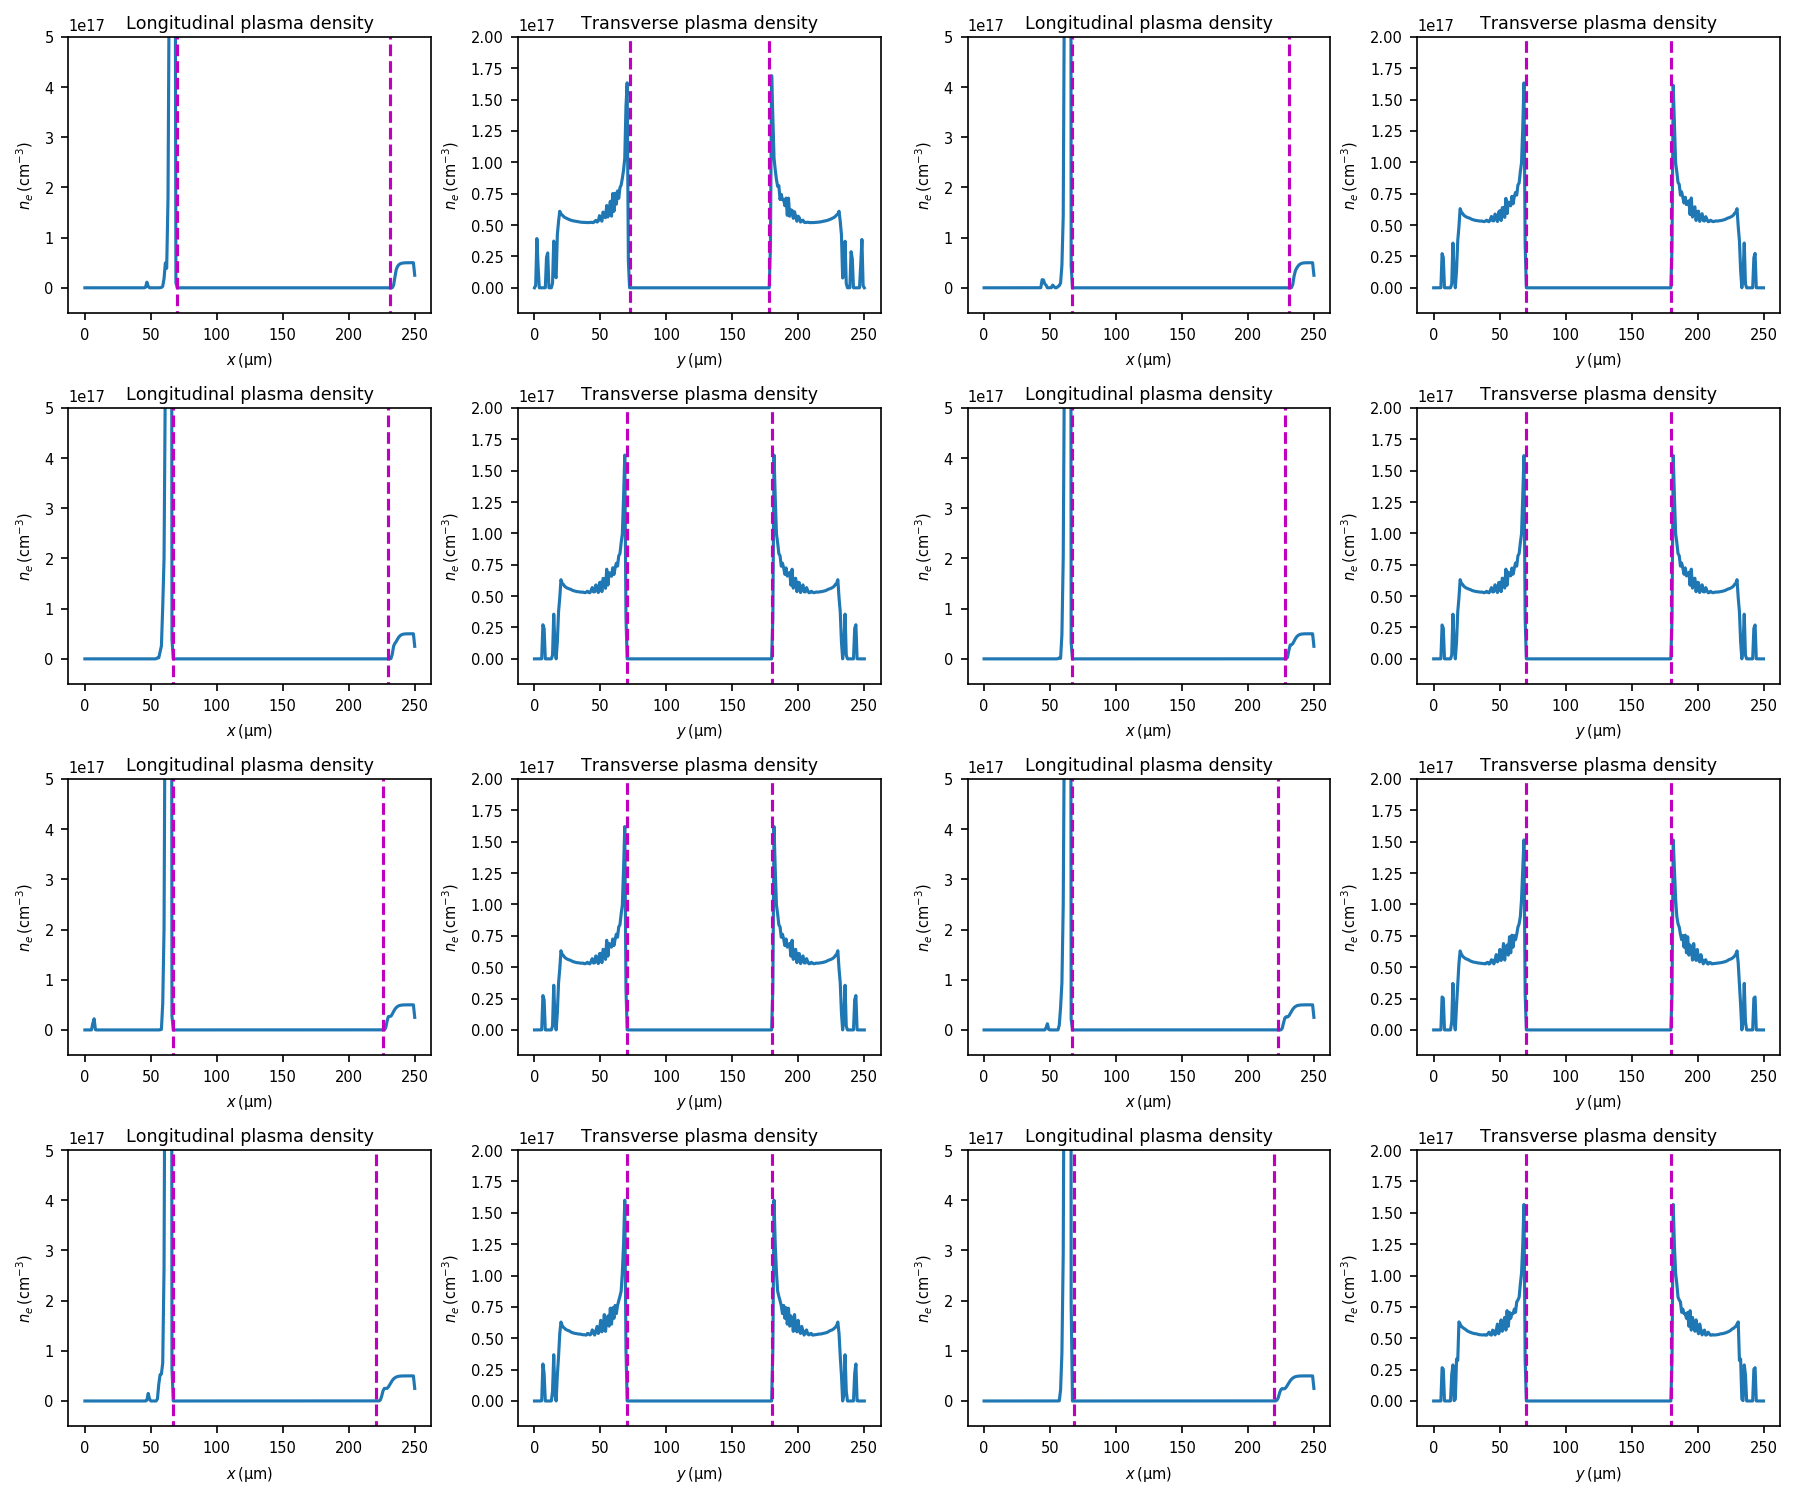

In [3]:
# Find the wake size for a single beam
sims = [
    '0.2um',
    '0.5um',
    '1um',
    '2um',
    '3um',
    '4um',
    '5um',
    '6um'
]
N = len(sims)
length = np.zeros(N, dtype='double')
width = np.zeros(N, dtype='double')

plt.figure(figsize=(12,10), dpi=150)
gs = gridspec.GridSpec(4, 4)
row = [0, 0, 1, 1, 2, 2, 3, 3]
col = [0, 2, 0, 2, 0, 2, 0, 2]

for i in range(N):
    path = pathPre + sims[i] +'/'
    rho, rhoAttrs = load.load_field(path, simName, 'rhoPlasma')
    Nx, Ny, Nz = analyze.get_shape(rho[5])
    x = np.linspace(0, 250, Nx)
    y = np.linspace(0, 250, Ny)
    rho = rho[5]
    rhoX = -rho[:, int(Ny+1)/2, int(Nz+1)/2, 0]/e/1e6
    rhoY = find_rhoY(rho, y, Ny, 50, 200)
    lStart, lEnd = find_length(rhoX, x, Nx)
    wStart, wEnd = find_width(rhoY, y, Ny)
    length[i] = lStart - lEnd
    width[i] = wEnd - wStart
    
    plt.subplot(gs[row[i], col[i]])
    plt.plot(x, rhoX)
    plt.plot([lStart, lStart], [-0.5e18, 5e18], 'm--')
    plt.plot([lEnd, lEnd], [-0.5e18, 5e18], 'm--')
    plt.title('Longitudinal plasma density')
    plt.xlabel(r'$x\,(\mathrm{\mu m})$')
    plt.ylabel(r'$n_e\,(\mathrm{cm^{-3}})$')
    plt.ylim([-0.5e17, 5e17])

    plt.subplot(gs[row[i], col[i]+1])
    plt.plot(y, rhoY)
    plt.title('Transverse plasma density')
    plt.plot([wStart, wStart], [-0.25e17, 2.5e17], 'm--')
    plt.plot([wEnd, wEnd], [-0.25e17, 2.5e17], 'm--')
    plt.xlabel(r'$y\,(\mathrm{\mu m})$')
    plt.ylabel(r'$n_e\,(\mathrm{cm^{-3}})$')
    plt.ylim([-0.2e17, 2e17])
plt.tight_layout()
plt.show()

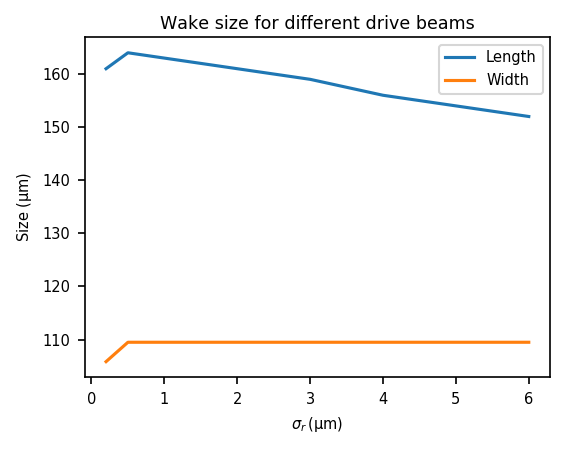

In [4]:
sigmar = [0.2, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
plt.figure(figsize=(4,3), dpi=150)
plt.plot(sigmar, length, sigmar, width)
plt.title('Wake size for different drive beams')
plt.xlabel(r'$\sigma_r\,\mathrm{(\mu m)}$')
plt.ylabel(r'Size ($\mathrm{\mu m})$')
plt.legend(['Length', 'Width'])
plt.show()

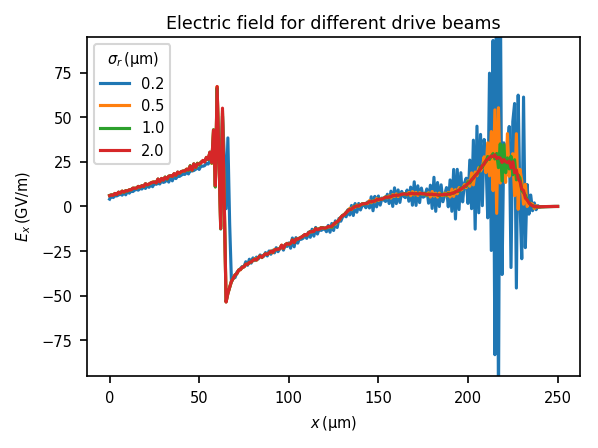

In [15]:
# Lets look at the accelerating field
plt.figure(figsize=(4,3), dpi=150)
for i in range(4):
    path = pathPre + sims[i] +'/'
    Efield, Eattrs = load.load_field(path, simName, 'edgeE')
    plt.plot(x, Efield[5][:, int((Ny+1)/2), int((Nz+1)/2), 0]/1e9)
plt.title('Electric field for different drive beams')
plt.xlabel(r'$x\,(\mathrm{\mu m})$')
plt.ylabel(r'$E_x\,(\mathrm{GV/m})$')
plt.legend(['0.2', '0.5', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0'], title=r'$\sigma_r\,\mathrm{(\mu m)}$')
plt.ylim([-95, 95])
plt.tight_layout()
plt.show()